# Prestack seismic

**[Smaller single gather file on S3/agilegeo (3.8GB)](https://s3.amazonaws.com/agilegeo/3D_gathers_pstm_nmo_X1001.sgy)**

**[Larger gathers files on Open Seismic Repository (ca. 10GB)](https://opendtect.org/osr/pmwiki.php/Main/PENOBSCOT3DSABLEISLAND)**

For now we'll satisfy ourselves with reading some prestack seismic data from disk, and looking at it.

Eventually we can:

- Extract prestack attributes from the gathers.
- Examine a well from one of the gather locations.
- Model the AVO behaviour at the well and compare to the prestack data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read the SEGY file

This is a large file — and this is only 1 of 30 or so files in this ca. 90GB dataset – so we will use `headonly=True` to only parse the headers with `_read_segy()`, then we can index into the stream as before. The difference is that this time, the data stays on disk until we do that read.

In [2]:
filename = '../data/3D_gathers_pstm_nmo_X1001.sgy'

In [3]:
from obspy.io.segy.segy import _read_segy

# Only read the headers, otherwise you will get memory issues
stream = _read_segy(filename, headonly=True)

In [4]:
stream

610412 traces in the SEG Y structure.

In [5]:
x = np.array(list(stream.textual_file_header.decode()))
print('\n'.join(''.join(row) for row in x.reshape((40, 80))))

C 1 PROCESSED FOR : OETR        AREA: NOVA SCOTIA   OFFSHORE                    
C 2 PROCESSED BY  : KELMAN SEISMIC PROCESSING, DECEMBER 2007                    
C 3 PROJECT       : PENOBSCOT-3D                                                
C 4 BIN LINES     : X LINES 1000-1040   Y LINES 1000-1481                       
C 5 BIN SIZE      : X INT 12.5M         Y INT 25M  DATUM:    0 M                
C 6 VERSION       :  PSTM  gathers  with true amplitude and nmo applied         
C 7 FORMAT: SEGY 32 BIT IBM FLOATING POINT  LENGTH: 0-6000 MS  SI: 4 MS         
C 8 TRACE HEADER INFORMATION                                                    
C 9 BYTE#  1-4  TRACE SEQUENCE # WITHIN VERSION			                              
C12 BYTE#  5-9  INCREMENTAL LINE  NUMBER CDP-X 			                              
C13 BYTE#  9-12 INCREMENTAL LINE  NUMBER CDP-Y		         	                      
C14 BYTE# 13-16 21-24 INCREMENTAL LINE NUMBER CDP-X 	                           
C15 BYTE# 17-20 25-28 INCREM

## Organize the data

This is where we get the data from disk. We'll just grab a bit. There are about 22 traces per gather, so we'll go for 100-ish gathers.

The tricky thing with this dataset is that there are a variable number of traces per gather, so we can't just read it like a regular 3D.

In [6]:
traces_to_read = 2200
data = np.vstack([t.data for t in stream.traces[:traces_to_read]])
gno = np.array([t.header.trace_number_within_the_ensemble for t in stream.traces[:traces_to_read]])

In [7]:
# We'll need the number of time samples.
_, t = data.shape

In [8]:
# Find the max number of traces in a gather.
values, counts = np.unique(gno, return_counts=True)

In [9]:
# Collect all the traces according to the trace header no.
gathers = np.vstack([data[gno==i] for i in values])

In [10]:
# Make a mask, False where there's no trace for that gather.
mask = np.arange(np.amax(counts)) < counts[:, None]

# We have to mask with a 1D array so make the out one row per trace.
out = np.zeros((mask.size, t))
out[np.ravel(mask)] = gathers

In [11]:
lines, traces = mask.shape

# Reshape back to the 3D geometry.
g3 = out.reshape(lines, traces, t)

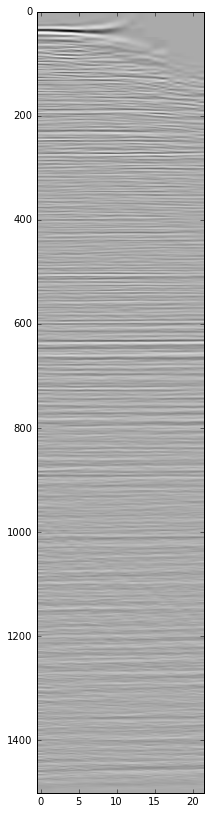

In [12]:
plt.figure(figsize=(3,14))
plt.imshow(g3[68].T, cmap='Greys', aspect='auto')
plt.show()

The stack is formed by averaging these traces, usually a swath of angles. So fewer traces contribute near the top; more at the bottom. The complete stack would look like this:

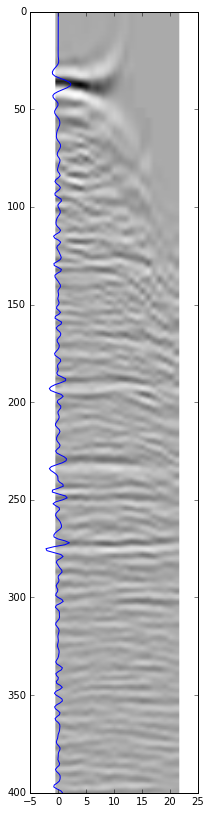

In [13]:
idx = np.arange(0, g3.shape[-1])
perc = np.percentile(g3, 95)

plt.figure(figsize=(3,14))
plt.imshow(g3[68].T, cmap='Greys', aspect='auto')
plt.plot(np.mean(g3[68], axis=0)/perc, idx)
plt.ylim(400, 0)
plt.show()

## Make an angle stack

We'll pretend there's a constant velocity of 2000 m/s to make life easier. Then 1 ms corresponds to 1 m, so with a sample interval of 4 ms, we're looking at 4 m samples in depth.

In the header, it says this:

    output offset pannels  175m - 3175m with bin size 50m   
    
I don't totally understand the bin size remark. We have 22 traces, we'll assume the near trace is 175 m offset, and the far is 3175 m.

$$ \tan \theta = \frac{x}{d} \ \ \mathrm{so} \ \ d = \frac{x}{\tan \theta} $$

In [14]:
theta = np.radians(30)
d = 4*idx / np.tan(theta)

# We need the index.
incr = 3175 / 22
d_i = 1 + (d // incr).astype(int)
d_i[d_i >= 22] = 22

In [15]:
d_i[:40]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

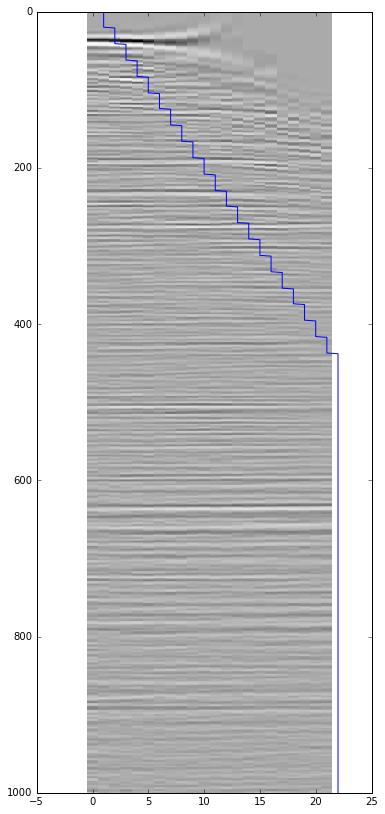

In [16]:
plt.figure(figsize=(6,14))
plt.imshow(g3[68].T, cmap='Greys', interpolation='none', aspect='auto')
plt.plot(d_i, idx)
plt.ylim(1000, 0)
plt.show()

We'll apply that as a mute. We'll make `NaN`s so we can easily drop them out of the mean.

In [17]:
# Bah, there has to be a more elegant way...
for gather in g3:
    for row, i in zip(gather.T, d_i):
        row[i:] = np.nan

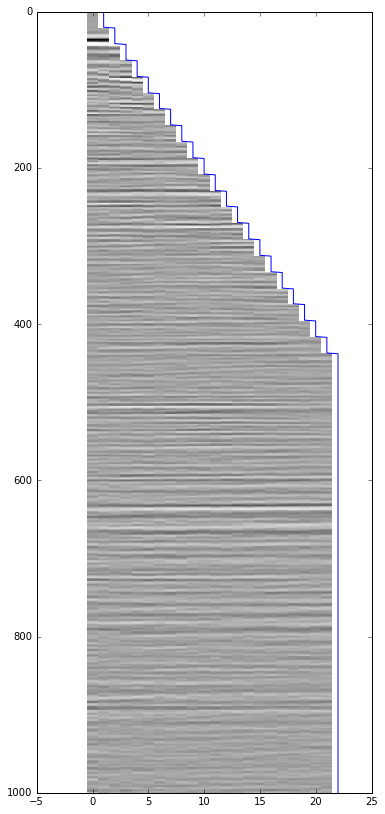

In [18]:
plt.figure(figsize=(6,14))
plt.imshow(g3[68].T, cmap='Greys', interpolation='none', aspect='auto')
plt.plot(d_i, idx)
plt.ylim(1000, 0)
plt.show()

## Make a stacked section

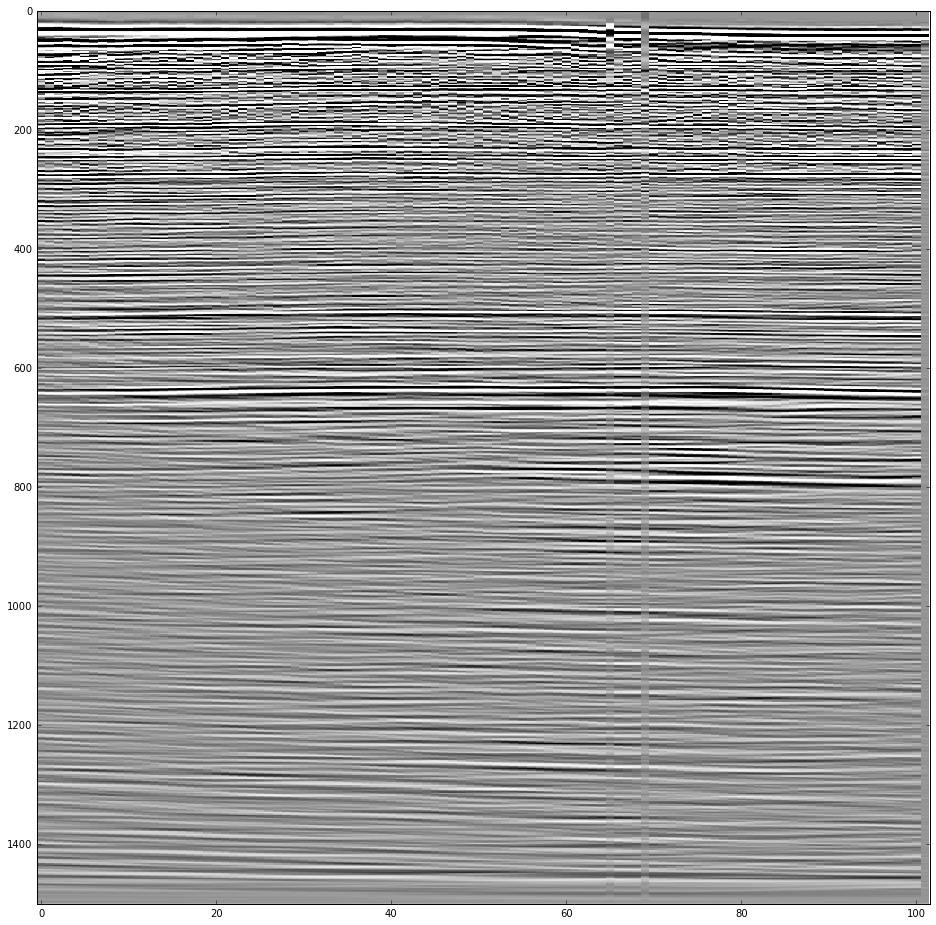

In [19]:
plt.figure(figsize=(16,16))
plt.imshow(np.nanmean(g3.T, axis=1), cmap='Greys', vmin=-perc, vmax=perc, interpolation='none', aspect='auto')
plt.show()

## The power of stack

Remember, one of the points of stacking is noise reduction. Let's look at a really noisy trace and see what happens when we stack it. We'll use the mean trace from before:

In [20]:
tr = np.nanmean(g3[68], axis=0)/perc

In [21]:
panel = np.repeat(tr, 50).reshape(tr.size, 50)

In [22]:
panel += np.random.random(panel.shape) * np.ptp(panel) - np.ptp(panel)/2

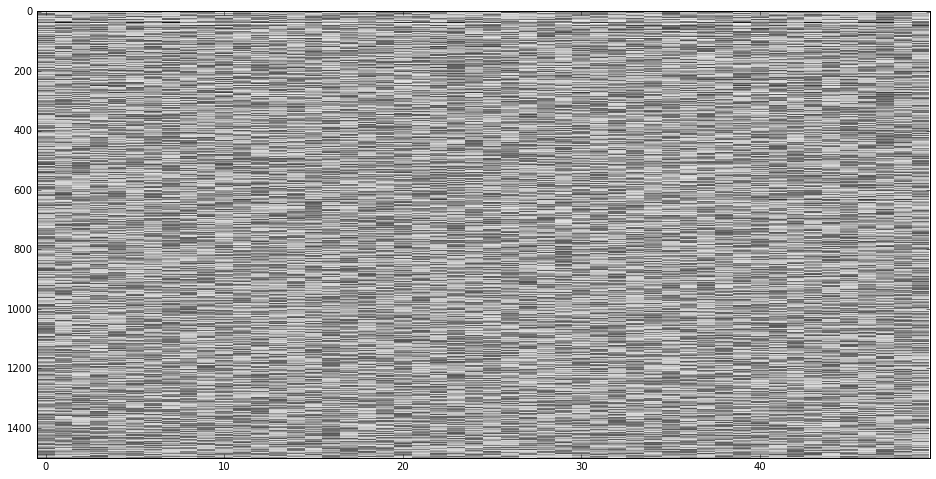

In [23]:
plt.figure(figsize=(16,8))
plt.imshow(panel, cmap="Greys", interpolation='none', aspect='auto')
plt.show()

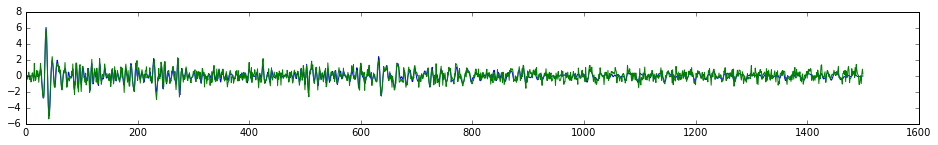

In [24]:
plt.figure(figsize=(16,2))
plt.plot(tr)
plt.plot(np.nanmean(panel, axis=1))
plt.show()

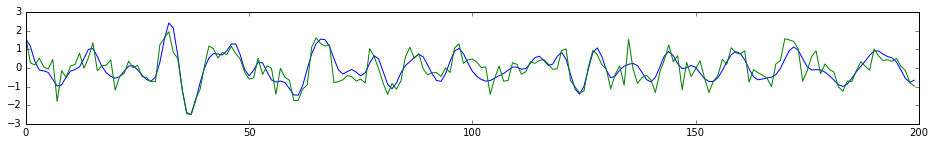

In [25]:
plt.figure(figsize=(16,2))
plt.plot(tr[600:800])
plt.plot(np.nanmean(panel, axis=1)[600:800])
plt.show()

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>